Reference: https://github.com/Farzad-R/Finetune-LLAVA-NEXT/blob/main/Notebooks/fine_tuning/fine_tune_llava_1.6_7b_on_cordv2.ipynb

In [1]:
!pip install torch pillow transformers peft datasets lightning wandb nltk bert-score -q

## Training

In [2]:
from datasets import load_dataset, Image
from PIL import Image as PILImage

from transformers import LlavaNextForConditionalGeneration, AutoProcessor
from peft import LoraConfig, get_peft_model, PeftModel

import torch
from torch.utils.data import Dataset, DataLoader
import lightning as L
from lightning.pytorch.callbacks import Callback
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from lightning.pytorch.loggers import WandbLogger

import re
from nltk import edit_distance
import numpy as np
import requests
import io
import gc
from bert_score import score as bert_score

from huggingface_hub import HfApi
from huggingface_hub import notebook_login

notebook_login()

MODEL_ID = "llava-hf/llava-v1.6-mistral-7b-hf"
REPO_ID = "AndresSebad/llava-v1.6-mistral-7b-memes-chilenos-small"
DATASET_ID = "AndresSebad/memes_instagram_chilenos_es_small"

WANDB_PROJECT = "LLaVaNeXTMemes"
WANDB_NAME = "llava-next-memes_chilenos_small"
WANDB_KEY = "90e0053adedf3ef5d182a9ca5142acebe91158ff"

In [3]:
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

In [4]:
MAX_LENGTH = 256

In [5]:
import wandb

wandb.login(key=WANDB_KEY)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /home/user/.netrc
wandb: Currently logged in as: andres-seba-ai (andres-seba-ai-uc) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [6]:
ds = load_dataset(DATASET_ID, trust_remote_code=True)
split_ds = ds['train']

def preprocess(dataset):
    cols_to_keep = ["image", "multiple_choice_answer", "instruction"]
    dataset = dataset.remove_columns([c for c in dataset.column_names if c not in cols_to_keep])
    return dataset

train_ds = preprocess(split_ds)
train_ds = train_ds.cast_column("image", Image(decode=True))
def resize_batch(examples):
    examples["image"] = [img.resize((336, 336)) for img in examples["image"]]
    return examples

# Los dejamos en 336x336 pixeles
train_ds = train_ds.map(resize_batch, batched=True)

README.md:   0%|          | 0.00/1.69k [00:00<?, ?B/s]

train-00000-of-00002.parquet:   0%|          | 0.00/108M [00:00<?, ?B/s]

train-00001-of-00002.parquet:   0%|          | 0.00/104M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/4776 [00:00<?, ? examples/s]

Map:   0%|          | 0/4776 [00:00<?, ? examples/s]

In [7]:
splits = train_ds.train_test_split(test_size=0.0001, seed=42)
train_ds = splits['train'] 
val_ds  = splits['test']

In [8]:
train_ds, val_ds

(Dataset({
     features: ['image', 'instruction', 'multiple_choice_answer'],
     num_rows: 4775
 }),
 Dataset({
     features: ['image', 'instruction', 'multiple_choice_answer'],
     num_rows: 1
 }))

In [9]:
processor = AutoProcessor.from_pretrained(MODEL_ID)
processor.tokenizer.padding_side = "right"

processor_config.json:   0%|          | 0.00/176 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/2.07k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/41.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

In [10]:
model = LlavaNextForConditionalGeneration.from_pretrained(
        MODEL_ID,
        torch_dtype=torch.float16
)

config.json:   0%|          | 0.00/1.28k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/70.2k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/380M [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

In [11]:
# Accedemos al backbone de mistral para cargar los pesos
model.language_model

MistralModel(
  (embed_tokens): Embedding(32064, 4096)
  (layers): ModuleList(
    (0-31): 32 x MistralDecoderLayer(
      (self_attn): MistralAttention(
        (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
        (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
        (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
        (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
      )
      (mlp): MistralMLP(
        (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
        (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
        (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
        (act_fn): SiLU()
      )
      (input_layernorm): MistralRMSNorm((4096,), eps=1e-05)
      (post_attention_layernorm): MistralRMSNorm((4096,), eps=1e-05)
    )
  )
  (norm): MistralRMSNorm((4096,), eps=1e-05)
  (rotary_emb): MistralRotaryEmbedding()
)

In [11]:
# Aplicamos Lora
def find_all_linear_names(model):
    cls = torch.nn.Linear
    lora_module_names = set()
    multimodal_keywords = ['multi_modal_projector', 'vision_model']
    for name, module in model.named_modules():
        if any(mm_keyword in name for mm_keyword in multimodal_keywords):
            continue
        if isinstance(module, cls):
            names = name.split('.')
            lora_module_names.add(names[0] if len(names) == 1 else names[-1])

    if 'lm_head' in lora_module_names: # needed for 16-bit
        lora_module_names.remove('lm_head')
    return list(lora_module_names)

lora_config = LoraConfig(
    r=8,
    lora_alpha=8,
    lora_dropout=0.1,
    target_modules=find_all_linear_names(model),
    init_lora_weights="gaussian",
)

model = get_peft_model(model, lora_config)

In [12]:
def find_all_linear_names(model, include_vision=False):
    cls = torch.nn.Linear
    lora_module_names = set()
    multimodal_keywords = [] if include_vision else ['multi_modal_projector', 'vision_model']

    for name, module in model.named_modules():
        if not include_vision and any(mm_keyword in name for mm_keyword in multimodal_keywords):
            continue
        if isinstance(module, cls):
            names = name.split('.')
            lora_module_names.add(names[0] if len(names) == 1 else names[-1])

    if 'lm_head' in lora_module_names:
        lora_module_names.remove('lm_head')

    return list(lora_module_names)

# Si quieres incluir visión
include_vision = True

# Descongelar encoder de visión si es necesario
if include_vision:
    model.vision_tower.requires_grad_(True)
    for param in model.vision_tower.parameters():
        param.requires_grad = True

# Aplicamos LoRA
lora_config = LoraConfig(
    r=8,
    lora_alpha=8,
    lora_dropout=0.1,
    target_modules=find_all_linear_names(model, include_vision=include_vision),
    init_lora_weights="gaussian",
)

model = get_peft_model(model, lora_config)

In [13]:
class LlavaNextDataset(Dataset):
    def __init__(
        self,
        dataset = None
    ):
        super().__init__()
        self.dataset = dataset

    def __len__(self) -> int:
        return len(self.dataset)

    def __getitem__(self, idx: int):
        sample = self.dataset[idx]
        image = sample["image"]
        target_sequence = sample["multiple_choice_answer"]
        instruction = sample["instruction"]
        return image, target_sequence, instruction

In [14]:
train_dataset = LlavaNextDataset(dataset=train_ds)
val_dataset = LlavaNextDataset(dataset=val_ds)

In [15]:
val_example = val_dataset[0]

image, target_sequence, instruction = val_example

print(instruction)
print(target_sequence)

Explica cómo entendería este meme alguien que vive en Chile, usando ejemplos culturales o referencias locales que ayuden a comprender el chiste.
El meme muestra a un caballero medieval súper motivado, listo para entrar en combate, y representa cómo nos sentimos los chilenos al enfrentar el mes de marzo. En Chile, marzo es famoso por ser un mes complicado: se acaban las vacaciones de verano, los niños vuelven al colegio, las deudas de las matrículas y útiles escolares pegan fuerte, y la pega se pone intensa porque todo se vuelve a activar. Es como cuando el cuerpo te pide estar "a prueba de balas" porque el año empieza de verdad. Este meme refleja esa sensación de estar listo para enfrentar el mes más "cuático" del año, con toda la fuerza y garra típica chilena.


In [16]:
def train_collate_fn(examples):
    images, ground_truths, instructions = zip(*examples)

    prompts = []
    for gt, instr in zip(ground_truths, instructions):
        conversation = [
            {
                "role": "user",
                "content": [
                    {"type": "image"},
                    {"type": "text", "text": "Eres experto en memes chilenos. Observa la imagen y, si hay texto, interprétalo sin repetirlo. Analiza su sentido usando contexto cultural chileno. Responde según la instrucción."},
                    {"type": "text", "text": instr},
                ],
            },
            {
                "role": "assistant",
                "content": [
                    {"type": "text", "text": gt},
                ],
            }
        ]
        prompt = processor.apply_chat_template(conversation, add_generation_prompt=False)
        prompts.append(prompt)

    batch = processor(
        text=prompts,
        images=list(images),
        return_tensors="pt"
    )

    labels = batch["input_ids"].clone()
    labels[labels == processor.tokenizer.pad_token_id] = -100
    batch["labels"] = labels

    return (
        batch["input_ids"],
        batch["attention_mask"],
        batch["pixel_values"],
        batch["image_sizes"],
        batch["labels"],
    )

def eval_collate_fn(examples):
    images, ground_truths, instructions = zip(*examples)

    prompts = []
    for instr in instructions:
        conversation = [
            {
                "role": "user",
                "content": [
                    {"type": "image"},
                    {"type": "text", "text": "Eres experto en memes chilenos. Observa la imagen y, si hay texto, interprétalo sin repetirlo. Analiza su sentido usando contexto cultural chileno. Responde brevemente según la instrucción."},
                    {"type": "text", "text": instr},
                ],
            }
        ]
        prompt = processor.apply_chat_template(conversation, add_generation_prompt=False)
        prompts.append(prompt)

    batch = processor(
        text=prompts,
        images=list(images),
        return_tensors="pt"
    )

    return (
        batch["input_ids"],
        batch["attention_mask"],
        batch["pixel_values"],
        batch["image_sizes"],
        list(ground_truths),
    )

In [19]:
class LlavaModelPLModule(L.LightningModule):
    def __init__(self, config, processor, model):
        super().__init__()
        self.config = config
        self.processor = processor
        self.model = model

        self.batch_size = config.get("batch_size")

    def training_step(self, batch, batch_idx):
        input_ids, attention_mask, pixel_values, image_sizes, labels = batch

        outputs = self.model(input_ids=input_ids,
                            attention_mask=attention_mask,
                            pixel_values=pixel_values,
                            image_sizes=image_sizes,
                            labels=labels
                          )
        loss = outputs.loss

        self.log("train_loss", loss)

        return loss

    def on_validation_start(self):
        self.n_val_printed = 0  # Reiniciamos contador de la validación

    #def validation_step(self, batch, batch_idx, dataset_idx=0):
    #    input_ids, attention_mask, pixel_values, image_sizes, answers = batch
    #
    #    generated_ids = self.model.generate(input_ids=input_ids, attention_mask=attention_mask,
    #                                   pixel_values=pixel_values, image_sizes=image_sizes, max_new_tokens=MAX_LENGTH)
    #    predictions = self.processor.batch_decode(generated_ids[:, input_ids.size(1):], skip_special_tokens=True)
    #
    #    scores = []
    #    for pred, answer in zip(predictions, answers):
    #        scores.append(edit_distance(pred, answer) / max(len(pred), len(answer)))
    #
    #        if self.config.get("verbose", False) and self.n_val_printed < 2:
    #            print(f"Prediction: {pred}")
    #            print(f"    Answer: {answer}")
    #            print(f" Normed ED: {scores[0]}")
    #            self.n_val_printed += 1 # Asi imprimimos solo dos ejemplos
    #
    #    self.log("val_edit_distance", np.mean(scores))
    #
    #    return scores

    def validation_step(self, batch):
        input_ids, attention_mask, pixel_values, image_sizes, answers = batch
    
        generated_ids = self.model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            pixel_values=pixel_values,
            image_sizes=image_sizes,
            max_new_tokens=MAX_LENGTH
        )
    
        predictions = self.processor.batch_decode(generated_ids[:, input_ids.size(1):], skip_special_tokens=True)
    
        # EDIT DISTANCE
        ed_scores = []
        for pred, answer in zip(predictions, answers):
            ed_scores.append(edit_distance(pred, answer) / max(len(pred), len(answer)))
    
        self.log("val_edit_distance", np.mean(ed_scores))
    
        # BERTScore
        P, R, F1 = bert_score(predictions, answers, lang="es", verbose=False)
        mean_f1 = F1.mean().item()
        self.log("val_bertscore_f1", mean_f1, prog_bar=True)
    
        # Verbose ejemplos
        if self.config.get("verbose", False) and self.n_val_printed < 3:
            print(f"Prediction: {predictions[0]}")
            print(f"    Answer: {answers[0]}")
            print(f" Normed ED: {ed_scores[0]}")
            print(f" BERTScore F1: {F1[0].item():.4f}")
            self.n_val_printed += 1
    
        return {"edit_distance": np.mean(ed_scores), "bertscore_f1": mean_f1}

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.config.get("lr"))

        scheduler = torch.optim.lr_scheduler.LinearLR(
            optimizer,
            start_factor=1.0,        # parte en 1e-4
            end_factor=0.125,        # termina en 2e-5 (20% de 1e-4)
            total_iters=self.config.get("max_epochs")
        )
    
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "epoch",  # actualiza cada epoch
                "frequency": 1
            }
        }

    def train_dataloader(self):
        return DataLoader(train_dataset, collate_fn=train_collate_fn, batch_size=self.batch_size, shuffle=True, num_workers=4)

    def val_dataloader(self):
        return DataLoader(val_dataset, collate_fn=eval_collate_fn, batch_size=self.batch_size, shuffle=False, num_workers=4)

In [20]:
config = {"max_epochs": 2,
          #"val_check_interval": 0.5,
          #"check_val_every_n_epoch": 0,
          "gradient_clip_val": 1.0,
          "accumulate_grad_batches": 8,
          "lr": 1e-4, # 1e-4 5e-5 2e-5
          "batch_size": 1,
          "num_nodes": 1,
          "warmup_steps": 50,
          "result_path": "./result",
          "verbose": True,
          "num_workers": 4
}

model_module = LlavaModelPLModule(config, processor, model)

In [21]:
!pip install codecarbon

     |████████████████████████████████| 610 kB 24.1 MB/s eta 0:00:01
     |████████████████████████████████| 243 kB 103.8 MB/s eta 0:00:01
     |████████████████████████████████| 46 kB 21.1 MB/s eta 0:00:01
     |████████████████████████████████| 3.1 MB 91.5 MB/s eta 0:00:01
     |████████████████████████████████| 92 kB 3.6 MB/s  eta 0:00:01
     |████████████████████████████████| 76 kB 25.9 MB/s eta 0:00:01
     |████████████████████████████████| 47 kB 26.4 MB/s eta 0:00:01
     |████████████████████████████████| 87 kB 35.5 MB/s eta 0:00:01
  Attempting uninstall: httpx
    Found existing installation: httpx 0.28.1
    Uninstalling httpx-0.28.1:
      Successfully uninstalled httpx-0.28.1


In [24]:
from codecarbon import EmissionsTracker

api = HfApi()

class PushToHubCallback(Callback):
    def on_train_epoch_end(self, trainer, pl_module):
        print(f"Subiendo modelo a Hub en HF, epoch {trainer.current_epoch}")
        pl_module.model.push_to_hub(REPO_ID,
                                    commit_message=f"Entrenamiento en Progreso, epoch {trainer.current_epoch}")
    def on_train_end(self, trainer, pl_module):
        print(f"Subiendo modelo y procesador a Hub en HF")
        pl_module.processor.push_to_hub(REPO_ID,
                                    commit_message=f"Entrenamiento Terminado.")
        pl_module.model.push_to_hub(REPO_ID,
                                    commit_message=f"Entrenamiento Terminado.")

class CodeCarbonPLCallback(Callback):
    def __init__(self, project_name="lightning-training", output_dir="codecarbon_logs"):
        super().__init__()
        self.tracker = EmissionsTracker(project_name=project_name, output_dir=output_dir)

    def on_train_start(self, trainer, pl_module):
        self.tracker.start()

    def on_train_end(self, trainer, pl_module):
        self.tracker.stop()

early_stop_callback = EarlyStopping(monitor="val_bertscore_f1", patience=3, verbose=False, mode="max")

In [25]:
%%time

wandb_logger = WandbLogger(
    project=WANDB_PROJECT
)

checkpoint_callback = ModelCheckpoint(
    monitor="val_bertscore_f1",  
    mode="max",                   
    save_top_k=1,                 
    verbose=True,
    filename="best-checkpoint-{epoch:02d}-{val_bertscore_f1:.4f}"
)

trainer = L.Trainer(
        accelerator="gpu",
        devices=[0],
        max_epochs=config.get("max_epochs"),
        val_check_interval=config.get("val_check_interval"),
        accumulate_grad_batches=config.get("accumulate_grad_batches"),
        check_val_every_n_epoch=config.get("check_val_every_n_epoch"),
        gradient_clip_val=config.get("gradient_clip_val"),
        precision="16-mixed",
        #limit_val_batches=0,
        num_sanity_val_steps=0,
        logger=wandb_logger,
        callbacks=[
            #PushToHubCallback(),
            early_stop_callback,
            checkpoint_callback,
            CodeCarbonPLCallback()
        ],
)

trainer.fit(model_module)

[codecarbon WARNING @ 00:00:23] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 00:00:23] [setup] RAM Tracking...
[codecarbon INFO @ 00:00:23] [setup] CPU Tracking...
[codecarbon WARNING @ 00:00:24] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 00:00:24] CPU Model on constant consumption mode: AMD EPYC 7R13 Processor
[codecarbon WARNING @ 00:00:24] No CPU tracking mode found. Falling back on CPU load mode.
[codecarbon INFO @ 00:00:24] [setup] GPU Tracking...
[codecarbon INFO @ 00:00:24] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 00:00:24] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: cpu_load
                GPU Tracking Method: pynvml
            
[codecarbon INFO @ 00:00:24] >>> 

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type      | Params | Mode 
--------------------------------------------
0 | model | PeftModel | 7.6 B  | train
--------------------------------------------
24.6 M    Trainable params
7.6 B     Non-trainable params
7.6 B     Total params
30,365.458Total estimated model params size (MB)
3702      Modules in train mode
725       Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.
[codecarbon INFO @ 00:00:46] Energy consumed for RAM : 0.000086 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:00:47] Delta energy consumed for CPU with cpu_load : 0.000148 kWh, power : 34.35000000000001 W
[codecarbon INFO @ 00:00:47] Energy consumed for All CPU : 0.000148 kWh
[codecarbon INFO @ 00:00:47] Energy consumed for all GPUs : 0.001257 kWh. Total GPU Power : 282.7158951087082 W
[codecarbon INFO @ 00:00:47] 0.001491 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:01:01] Energy consumed for RAM : 0.000167 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:01:02] Delta energy consumed for CPU with cpu_load : 0.000134 kWh, power : 33.2578125 W
[codecarbon INFO @ 00:01:02] Energy consumed for All CPU : 0.000282 kWh
[codecarbon INFO @ 00:01:02] Energy consumed for all GPUs : 0.002539 kWh. Total GPU Power : 307.5984939466967 W
[codecarbon INFO @ 00:01:02] 0.002987 kWh

Validation: |          | 0/? [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
[codecarbon INFO @ 00:42:17] Energy consumed for RAM : 0.013448 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:42:17] Delta energy consumed for CPU with cpu_load : 0.000125 kWh, power : 31.0640625 W
[codecarbon INFO @ 00:42:17] Energy consumed for All CPU : 0.022536 kWh
[codecarbon INFO @ 00:42:17] Energy consumed for all GPUs : 0.217759 kWh. Total GPU Power : 250.79961364919745 W
[codecarbon INFO @ 00:42:17] 0.253743 kWh of electricity used since the beginning.
/home/user/miniconda/lib/python3.9/site-packages/lightning/pytorch/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Epoch 0, global step 597: 'val_bertscore_f1' reached 0.71428 (best 0.71428), saving model to './LLaVaNeXTMemes/vcx8j5vl/checkpoints/best-checkpoint-epoch=00-val_bertscore_f1=0.7143.ckpt' as top 1


Prediction: Este meme muestra a un caballero medieval en armadura pesada, listo para la batalla, y el texto dice "marzo de nuevo ctm, a dar cara". En Chile, "ctm" es una abreviatura de "conchetumare", que es una expresión común para mostrar frustración o resignación. La frase "a dar cara" significa enfrentar lo que venga, aunque sea algo difícil o incómodo. Es como cuando en marzo se empieza a sentir que el año se está volviendo más largo y hay que ponerse las pilas para enfrentar la rutina, el transporte público, el tráfico o incluso el taco en la Alameda. Es un chiste que mezcla humor con resignación, algo que los chilenos entienden bien, ya que siempre hay que ponerse las pilas para sobrellevar la vida diaria.
    Answer: El meme muestra a un caballero medieval súper motivado, listo para entrar en combate, y representa cómo nos sentimos los chilenos al enfrentar el mes de marzo. En Chile, marzo es famoso por ser un mes complicado: se acaban las vacaciones de verano, los niños vuelve

[codecarbon INFO @ 00:42:32] Energy consumed for RAM : 0.013529 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:42:32] Delta energy consumed for CPU with cpu_load : 0.000164 kWh, power : 40.725 W
[codecarbon INFO @ 00:42:32] Energy consumed for All CPU : 0.022700 kWh
[codecarbon INFO @ 00:42:32] Energy consumed for all GPUs : 0.218406 kWh. Total GPU Power : 155.11695709101602 W
[codecarbon INFO @ 00:42:32] 0.254634 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:42:32] 0.034479 g.CO2eq/s mean an estimation of 1,087.3146431649106 kg.CO2eq/year
[codecarbon INFO @ 00:42:47] Energy consumed for RAM : 0.013609 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:42:47] Delta energy consumed for CPU with cpu_load : 0.000127 kWh, power : 31.5421875 W
[codecarbon INFO @ 00:42:47] Energy consumed for All CPU : 0.022827 kWh
[codecarbon INFO @ 00:42:47] Energy consumed for all GPUs : 0.218941 kWh. Total GPU Power : 128.62701024600827 W
[codecarbon INFO @ 00:42:47] 0.255377 kWh of electr

Validation: |          | 0/? [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
[codecarbon INFO @ 01:26:02] Energy consumed for RAM : 0.027538 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:26:03] Delta energy consumed for CPU with cpu_load : 0.000129 kWh, power : 32.1328125 W
[codecarbon INFO @ 01:26:03] Energy consumed for All CPU : 0.045865 kWh
[codecarbon INFO @ 01:26:03] Energy consumed for all GPUs : 0.439256 kWh. Total GPU Power : 263.88703768767726 W
[codecarbon INFO @ 01:26:03] 0.512659 kWh of electricity used since the beginning.
Epoch 1, global step 1194: 'val_bertscore_f1' reached 0.74397 (best 0.74397), saving model to './LLaVaNeXTMemes/vcx8j5vl/checkpoints/best-checkpoint-epoch=01-val_bertscore_f1=0.7440.ckpt' as top 1


Prediction: Este meme muestra a un caballero medieval en armadura, listo para la batalla, con la frase "marzo de nuevo ctm a dar cara". En Chile, marzo es conocido por ser un mes lleno de eventos, como las Fiestas Patrias, las Fiestas de la Familia, y la Semana Santa, donde hay que estar siempre atento a cosas como el Transantiago lleno, los carretes, y las reuniones familiares. Es como cuando llega el mes de mayo y ya te toca enfrentar el Transantiago repleto, los carretes de Año Nuevo y las reuniones de familia. Es un reflejo de cómo en Chile siempre hay que estar preparado para enfrentar la rutina y los eventos que vienen con el mes.
    Answer: El meme muestra a un caballero medieval súper motivado, listo para entrar en combate, y representa cómo nos sentimos los chilenos al enfrentar el mes de marzo. En Chile, marzo es famoso por ser un mes complicado: se acaban las vacaciones de verano, los niños vuelven al colegio, las deudas de las matrículas y útiles escolares pegan fuerte, y 

[codecarbon INFO @ 01:26:17] Energy consumed for RAM : 0.027618 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:26:18] Delta energy consumed for CPU with cpu_load : 0.000129 kWh, power : 31.95 W
[codecarbon INFO @ 01:26:18] Energy consumed for All CPU : 0.045994 kWh
[codecarbon INFO @ 01:26:18] Energy consumed for all GPUs : 0.439863 kWh. Total GPU Power : 145.6667590450437 W
[codecarbon INFO @ 01:26:18] 0.513475 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:26:32] Energy consumed for RAM : 0.027699 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:26:33] Delta energy consumed for CPU with cpu_load : 0.000110 kWh, power : 27.45 W
[codecarbon INFO @ 01:26:33] Energy consumed for All CPU : 0.046104 kWh
[codecarbon INFO @ 01:26:33] Energy consumed for all GPUs : 0.440345 kWh. Total GPU Power : 115.78913969449601 W
[codecarbon INFO @ 01:26:33] 0.514148 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:26:33] 0.031829 g.CO2eq/s mean an estimation of 1,003.750

CPU times: user 1h 2min 50s, sys: 22min 48s, total: 1h 25min 38s
Wall time: 1h 27min 22s


In [22]:
model = model.to("cuda")
model = model.eval()

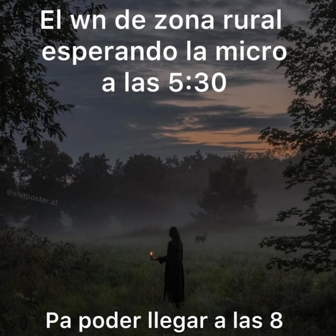

In [23]:
img = PILImage.open('rural.png')
img = img.convert('RGB')
img = img.resize((336, 336))
img

In [24]:
conversation = [
            {
                "role": "user",
                "content": [
                    {"type": "image"},
                    {"type": "text", "text": "Eres experto en memes chilenos. Observa la imagen y, si hay texto, interprétalo sin repetirlo. Analiza su sentido usando contexto cultural chileno. Responde según la instrucción."},
                    {"type": "text", "text": "Explica qué significa este meme en Chile, usando lenguaje coloquial chileno."},
                ],
            }
]

text_prompt = processor.apply_chat_template(conversation, add_generation_prompt=True)
batch = processor(text=text_prompt, images=[img], return_tensors="pt").to("cuda")

input_ids = batch["input_ids"]
attention_mask = batch["attention_mask"]
pixel_values = batch["pixel_values"]
image_sizes = batch["image_sizes"]

In [25]:
generated_ids = model.generate(
    input_ids=input_ids,
    attention_mask=attention_mask,
    pixel_values=pixel_values,
    image_sizes=image_sizes,
    max_new_tokens=MAX_LENGTH
)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


In [26]:
predictions = processor.batch_decode(generated_ids[:, input_ids.size(1):], skip_special_tokens=True)

In [27]:
predictions[0]

'Este meme muestra una escena bien mística y melancólica: una persona en una zona rural, probablemente en las afueras de Santiago, esperando la micro a las 5:30 de la mañana. La imagen tiene toda la onda de un viaje en la oscuridad, con humo de velas y una vibra de paz y reflexión.\n\nEl texto dice: “El wn de zona rural esperando la micro a las 5:30. Pa poder llegar a las 8.”\n\nY ahí está la talla: el viaje es largo, pero el viaje no es solo el trayecto. Es también el viaje del tiempo, porque la persona tiene que levantarse a una hora ridículamente temprana para llegar a su destino.'

In [29]:
model.push_to_hub(REPO_ID, commit_message=f"Modelo subido a HF.")

README.md:   0%|          | 0.00/15.0k [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/98.6M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/AndresSebad/llava-v1.6-mistral-7b-memes-chilenos-small/commit/cfaef35f0bdfe4c0436dbc552522a15cc6c14f09', commit_message='Modelo subido a HF.', commit_description='', oid='cfaef35f0bdfe4c0436dbc552522a15cc6c14f09', pr_url=None, repo_url=RepoUrl('https://huggingface.co/AndresSebad/llava-v1.6-mistral-7b-memes-chilenos-small', endpoint='https://huggingface.co', repo_type='model', repo_id='AndresSebad/llava-v1.6-mistral-7b-memes-chilenos-small'), pr_revision=None, pr_num=None)

### Save Best Model

In [26]:
#checkpoint = trainer.checkpoint_callback.best_model_path

In [27]:
#checkpoint

'./LLaVaNeXTMemes/c7axgpbg/checkpoints/best-checkpoint-epoch=00-val_bertscore_f1=0.7668.ckpt'

In [28]:
#model_module = LlavaModelPLModule.load_from_checkpoint(
#    checkpoint,
#    config=config,
#    processor=processor,
#    model=model
#)

#model_module = model_module.model.eval()

In [29]:
#model_module.push_to_hub(REPO_ID, commit_message=f"Mejor modelo subido a HF.")

README.md:   0%|          | 0.00/11.8k [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/98.6M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/AndresSebad/llava-v1.6-mistral-7b-memes-chilenos-small/commit/61e93493a43211f827326084ab748ddcecdbc085', commit_message='Mejor modelo subido a HF.', commit_description='', oid='61e93493a43211f827326084ab748ddcecdbc085', pr_url=None, repo_url=RepoUrl('https://huggingface.co/AndresSebad/llava-v1.6-mistral-7b-memes-chilenos-small', endpoint='https://huggingface.co', repo_type='model', repo_id='AndresSebad/llava-v1.6-mistral-7b-memes-chilenos-small'), pr_revision=None, pr_num=None)

## Test

In [5]:
model_nuevo = LlavaNextForConditionalGeneration.from_pretrained(
    MODEL_ID,
    torch_dtype=torch.float16
)

model_nuevo = PeftModel.from_pretrained(model_nuevo, "AndresSebad/llava-v1.6-mistral-7b-memes-chilenos-small")

model_nuevo = model_nuevo.eval()
model_nuevo = model_nuevo.to("cuda")

config.json:   0%|          | 0.00/1.28k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/70.2k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/380M [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/1.07k [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/98.6M [00:00<?, ?B/s]

In [6]:
processor = AutoProcessor.from_pretrained(MODEL_ID)
processor.tokenizer.padding_side = "right"

processor_config.json:   0%|          | 0.00/176 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/2.07k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/41.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

In [7]:
model_original = LlavaNextForConditionalGeneration.from_pretrained(
    MODEL_ID,
    torch_dtype=torch.float16
)
model_original = model_original.eval()
model_original = model_original.to("cuda")

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

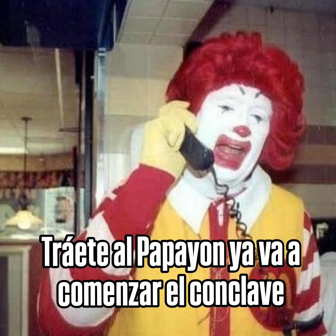

In [16]:
URLS_INSTAGRAM = [
"""
https://instagram.fscl20-1.fna.fbcdn.net/v/t51.2885-15/500039663_18303112792243547_4134073065575101782_n.jpg?stp=dst-jpg_e35_tt6&efg=eyJ2ZW5jb2RlX3RhZyI6IkZFRUQuaW1hZ2VfdXJsZ2VuLjExNDZ4MTE0Ni5zZHIuZjc1NzYxLmRlZmF1bHRfaW1hZ2UifQ&_nc_ht=instagram.fscl20-1.fna.fbcdn.net&_nc_cat=111&_nc_oc=Q6cZ2QHAmXULbRrydqTAEpvwxJrR_St6ExkjRx7zftxiOGVC-qg2q-IQMKZklY7K_M6MVpE&_nc_ohc=H3A0STq98poQ7kNvwHIPiRW&_nc_gid=eGCv9ct6CldDNIwhGx-kVg&edm=AP4sbd4BAAAA&ccb=7-5&ig_cache_key=MzYzODUxMjkxODEyODcyMjA2OA%3D%3D.3-ccb7-5&oh=00_AfJ9s8YULQsEPdFN50V0agsoRO_JBs4WrAW7mVOFFx3HBw&oe=683715F8&_nc_sid=7a9f4b
""",
"""
https://instagram.fscl36-1.fna.fbcdn.net/v/t51.2885-15/500673391_18303229561243547_8995403565645313815_n.jpg?stp=dst-jpg_e35_tt6&efg=eyJ2ZW5jb2RlX3RhZyI6IkZFRUQuaW1hZ2VfdXJsZ2VuLjEyNTJ4MTI1Mi5zZHIuZjc1NzYxLmRlZmF1bHRfaW1hZ2UifQ&_nc_ht=instagram.fscl36-1.fna.fbcdn.net&_nc_cat=1&_nc_oc=Q6cZ2QHAmXULbRrydqTAEpvwxJrR_St6ExkjRx7zftxiOGVC-qg2q-IQMKZklY7K_M6MVpE&_nc_ohc=UVHD0JPEyxQQ7kNvwH8tkFB&_nc_gid=eGCv9ct6CldDNIwhGx-kVg&edm=AP4sbd4BAAAA&ccb=7-5&ig_cache_key=MzYzOTIzMDIxODI0MjY3MzU5MA%3D%3D.3-ccb7-5&oh=00_AfLXz3DhrWLOxyEqGPMB1slxxfyotvJBIWOqdClQ1ned2Q&oe=68370EA9&_nc_sid=7a9f4b
""",
"""
https://instagram.fscl6-1.fna.fbcdn.net/v/t51.2885-15/497641340_18302249329243547_7318485400667289447_n.jpg?stp=dst-jpg_e35_tt6&efg=eyJ2ZW5jb2RlX3RhZyI6IkZFRUQuaW1hZ2VfdXJsZ2VuLjExNTV4MTE1NS5zZHIuZjc1NzYxLmRlZmF1bHRfaW1hZ2UifQ&_nc_ht=instagram.fscl6-1.fna.fbcdn.net&_nc_cat=111&_nc_oc=Q6cZ2QEFATBHAvQsmOgiliznPM2vXANpriYi1hyfiM5IR4dBu4myyOrIrbS82yrP9TAT5_3tc7VkrmM0rJrYoxqMwehX&_nc_ohc=DINjdDZXHHIQ7kNvwFtQvrz&_nc_gid=GP9NQX7az94rjyT0ZnNtXQ&edm=AP4sbd4BAAAA&ccb=7-5&ig_cache_key=MzYzMzA1Mjk1NDA0ODMwOTMxMg%3D%3D.3-ccb7-5&oh=00_AfL2qUL_ph5JnP0WqpmOvzIY3nbX9cVt8UXTead7o-Zudg&oe=68382222&_nc_sid=7a9f4b
""",
"""
https://instagram.fscl6-1.fna.fbcdn.net/v/t51.2885-15/476393559_18268515319251255_36262322876040549_n.jpg?stp=dst-jpg_e35_s720x720_tt6&efg=eyJ2ZW5jb2RlX3RhZyI6IkZFRUQuaW1hZ2VfdXJsZ2VuLjExNzl4MTAzOS5zZHIuZjc1NzYxLmRlZmF1bHRfaW1hZ2UifQ&_nc_ht=instagram.fscl6-1.fna.fbcdn.net&_nc_cat=103&_nc_oc=Q6cZ2QF6Ya79tR-LLB-WSeZG2IOiSMQ_sQGGiDW0UOXQ9zKKMzhObEJCSquJnemp_FwimoC3rzAM82cext3drhl2M3R3&_nc_ohc=xq2bIQVZxdoQ7kNvwEPoRF1&_nc_gid=EgHnA5TRsmvYbwgbYHwn3g&edm=ALQROFkBAAAA&ccb=7-5&ig_cache_key=MzU2MDk3NTk4MDkzMzA2NDc3MA%3D%3D.3-ccb7-5&oh=00_AfLPVgreOyZyIphODrru1OMSJhAJSsLS-mcqBhtldaEZ2Q&oe=6839725C&_nc_sid=fc8dfb
""",
"""
https://instagram.fscl6-1.fna.fbcdn.net/v/t51.29350-15/472380364_1420799205770770_5027309207086083608_n.jpg?stp=dst-jpg_e35_tt6&efg=eyJ2ZW5jb2RlX3RhZyI6IkZFRUQuaW1hZ2VfdXJsZ2VuLjEyNDB4MTMwNC5zZHIuZjI5MzUwLmRlZmF1bHRfaW1hZ2UifQ&_nc_ht=instagram.fscl6-1.fna.fbcdn.net&_nc_cat=110&_nc_oc=Q6cZ2QFPUHlYeIWlf6cwBl_lI65AxcYbdw4Y8wH9SJp5Koclsw3wVBQF-JgJVPVVb9f3BqPt7UQ_3Imjt3F2pnXgX-XR&_nc_ohc=EC046zI2QMsQ7kNvwGATAyJ&_nc_gid=9oGfr0i2Dp4inmBQ3XrWDQ&edm=ALQROFkBAAAA&ccb=7-5&ig_cache_key=MzUzODE1NTIyNTgzNzI1MzMxNA%3D%3D.3-ccb7-5&oh=00_AfJiETtcyb3oJdS8F1bUOmFMNFWaWfsunxqNNtLERnmGgg&oe=68395216&_nc_sid=fc8dfb
""",
"""
https://instagram.fscl6-1.fna.fbcdn.net/v/t51.2885-15/485587555_18296633173243547_7833863729808961215_n.jpg?stp=dst-jpg_e35_tt6&efg=eyJ2ZW5jb2RlX3RhZyI6IkZFRUQuaW1hZ2VfdXJsZ2VuLjExNzl4OTA3LnNkci5mNzU3NjEuZGVmYXVsdF9pbWFnZSJ9&_nc_ht=instagram.fscl6-1.fna.fbcdn.net&_nc_cat=111&_nc_oc=Q6cZ2QFcVVDuO6T-6C0Fp2xEc8TmX-Tor61CRi0l-VAFX0w26WLndOMHA5KmCIa0muzJTlaEPdKGUTs67aj-May8sFsf&_nc_ohc=6qG_1jw7jmwQ7kNvwHjPW3Z&_nc_gid=DkMZjk7uBqhtu-kAmMwpYw&edm=APoiHPcBAAAA&ccb=7-5&ig_cache_key=MzU5NTAzNjgyOTcwMDIwMTgwNQ%3D%3D.3-ccb7-5&oh=00_AfKnCdFEqRgqtWebHklzRwnwKBeJ_rDnvRb8k8c95AHqvA&oe=683A422F&_nc_sid=22de04
""",
"""
https://instagram.fscl20-1.fna.fbcdn.net/v/t51.2885-15/497550611_18499132669005612_3127707494598308246_n.jpg?stp=dst-jpg_e35_tt6&efg=eyJ2ZW5jb2RlX3RhZyI6IkZFRUQuaW1hZ2VfdXJsZ2VuLjEyNDJ4ODYwLnNkci5mNzU3NjEuZGVmYXVsdF9pbWFnZSJ9&_nc_ht=instagram.fscl20-1.fna.fbcdn.net&_nc_cat=100&_nc_oc=Q6cZ2QGeQOVw0Qgml1C8yNOQkERVSkursvkwV8nAjde8iWS2PeQhK2J5A7SPjB3iabtL0R0&_nc_ohc=Zr5_yMBTA-AQ7kNvwFhTk8_&_nc_gid=1ERhZNUowgIrs4QydfKb1Q&edm=APs17CUBAAAA&ccb=7-5&ig_cache_key=MzYzMjAwNzA2ODg1MzEwMzE2Ng%3D%3D.3-ccb7-5&oh=00_AfLx56ctM-oqSHn7xvaMnHxFMLybUJcRscHfzTiozFTc7A&oe=683AFB6C&_nc_sid=10d13b
""",
"""
https://instagram.fscl20-1.fna.fbcdn.net/v/t51.2885-15/497159471_18498597742005612_3395417364655245171_n.jpg?stp=dst-jpg_e35_tt6&efg=eyJ2ZW5jb2RlX3RhZyI6IkZFRUQuaW1hZ2VfdXJsZ2VuLjEyOTB4MTE3Ny5zZHIuZjc1NzYxLmRlZmF1bHRfaW1hZ2UifQ&_nc_ht=instagram.fscl20-1.fna.fbcdn.net&_nc_cat=100&_nc_oc=Q6cZ2QGUgKcgBL3ds0PlVRBRn2yyXiLv6AdWdLXHlGDVMSFWkHriYylFVWLBH6Cza5e5YqM&_nc_ohc=6nUzuu7mL0oQ7kNvwF3fu3T&_nc_gid=pTUAafJt2wW-LnM1olsqcA&edm=APs17CUBAAAA&ccb=7-5&ig_cache_key=MzYyOTkyNjU0MTkzMzg4NzA5NQ%3D%3D.3-ccb7-5&oh=00_AfJF0IvjRmzOR3QUVLL71maCJNhfzzI5ksXQHccWuS4jGg&oe=683B0727&_nc_sid=10d13b
""",
"""
https://instagram.fscl20-1.fna.fbcdn.net/v/t51.2885-15/495658211_18497623819005612_892183554127187320_n.jpg?stp=dst-jpg_e35_tt6&efg=eyJ2ZW5jb2RlX3RhZyI6IkZFRUQuaW1hZ2VfdXJsZ2VuLjEzNTB4MTQxMy5zZHIuZjc1NzYxLmRlZmF1bHRfaW1hZ2UifQ&_nc_ht=instagram.fscl20-1.fna.fbcdn.net&_nc_cat=100&_nc_oc=Q6cZ2QGJ_xtHkS28Btb4gBncemjaiEksaLpgoOqsRR0XHnzbz1gJcqrhMF16dJj-qGnEk7U&_nc_ohc=QBXR5awIzUwQ7kNvwHGLBMW&_nc_gid=EVvrUhyXiWZPrGLOS2u8SQ&edm=APs17CUBAAAA&ccb=7-5&ig_cache_key=MzYyNTk4Nzc0MDc1Nzc5Njc5Mw%3D%3D.3-ccb7-5&oh=00_AfLwH8ZROmOXGNFgU_8ntH6KhLgxslwsjuXR9H8eVob4NQ&oe=683AEF9E&_nc_sid=10d13b
""",
"""
https://instagram.fscl20-1.fna.fbcdn.net/v/t51.2885-15/491893079_18496045795005612_4102262762091988465_n.jpg?stp=dst-jpg_e35_tt6&efg=eyJ2ZW5jb2RlX3RhZyI6IkZFRUQuaW1hZ2VfdXJsZ2VuLjEyOTB4MTIyNS5zZHIuZjc1NzYxLmRlZmF1bHRfaW1hZ2UifQ&_nc_ht=instagram.fscl20-1.fna.fbcdn.net&_nc_cat=100&_nc_oc=Q6cZ2QFpxhhIsne1hWOdgyw_TAiDPxyrDr4nIvNiQVf4pRQdtJK6jGD-LoTX_BjN_YVj7ic&_nc_ohc=coAcxU_y62MQ7kNvwGUdGH_&_nc_gid=ombuPsvLUxCzqsR0bpFlfw&edm=APs17CUBAAAA&ccb=7-5&ig_cache_key=MzYxOTU1MDk4NTQ5NDE1MTk1MA%3D%3D.3-ccb7-5&oh=00_AfJAjn89g8GXngki6dH0cW4bLVrQ_jVyAiKdBJMD1jm2eA&oe=683AE447&_nc_sid=10d13b
""",
"""
https://instagram.fscl36-1.fna.fbcdn.net/v/t51.2885-15/487084643_18060242210011076_7349332086866503301_n.webp?efg=eyJ2ZW5jb2RlX3RhZyI6IkZFRUQuaW1hZ2VfdXJsZ2VuLjEwODB4MTA4MC5zZHIuZjc1NzYxLmRlZmF1bHRfaW1hZ2UifQ&_nc_ht=instagram.fscl36-1.fna.fbcdn.net&_nc_cat=108&_nc_oc=Q6cZ2QHdvcIEBw3Q7Hskm4SYEGLQIA-dHqltqzaP6FwuC95GUBfTqvl88FDCxVnZXzWrCdw&_nc_ohc=FQgJD2dFAakQ7kNvwEx1jg_&_nc_gid=FUhS4BnkQkNCVRP5CMcnMg&edm=APs17CUBAAAA&ccb=7-5&ig_cache_key=MzU5NzgwMjExMzYxNjE0NDI2OQ%3D%3D.3-ccb7-5&oh=00_AfJoEQs1gJvqCkm4AmXdc6XBIJcMS5riSgCiS8TYQJwx9A&oe=683AD8E2&_nc_sid=10d13b
""",
"""
https://instagram.fscl35-1.fna.fbcdn.net/v/t51.2885-15/497584821_18065240879080589_2343070439695168524_n.webp?stp=dst-webp_s1080x1080&efg=eyJ2ZW5jb2RlX3RhZyI6IkZFRUQuaW1hZ2VfdXJsZ2VuLjE0Mzd4MTEzNi5zZHIuZjc1NzYxLmRlZmF1bHRfaW1hZ2UifQ&_nc_ht=instagram.fscl35-1.fna.fbcdn.net&_nc_cat=105&_nc_oc=Q6cZ2QHXOybTcXaeOcTtHQHtmMoCXkBUk6W7hi35DYoo7lpV_66FPpnch1yzn-w13th8Dr4&_nc_ohc=2RUfguu5d2QQ7kNvwEIg-fF&_nc_gid=R6zJoZA-CSSz2PtLovr3Ww&edm=APs17CUBAAAA&ccb=7-5&ig_cache_key=MzYzMjYxOTMxMDk1NjE2NjcxNg%3D%3D.3-ccb7-5&oh=00_AfIYDD9YpdIxlk3B7sxjdDhRSMvw6xfNAlzM9o1GnGZ8VQ&oe=683AE80B&_nc_sid=10d13b
""",
"""
https://instagram.fscl6-1.fna.fbcdn.net/v/t51.2885-15/500383324_18278621302250351_8086361017757042571_n.jpg?stp=dst-jpg_e35_tt6&efg=eyJ2ZW5jb2RlX3RhZyI6IkZFRUQuaW1hZ2VfdXJsZ2VuLjEwMjR4MTAyNC5zZHIuZjc1NzYxLmRlZmF1bHRfaW1hZ2UifQ&_nc_ht=instagram.fscl6-1.fna.fbcdn.net&_nc_cat=111&_nc_oc=Q6cZ2QEOnBYqKgMG6ct8ri6f9PxeiVnwYmPwG6ogZSATf3jtYR5lLmdmxBSGyZFLcNw9M96mokwkBB8iveSH9eMsCZLf&_nc_ohc=LYMrqGkR-yAQ7kNvwHw9zPW&_nc_gid=vdUn7O0LXDws1yz8aKwkGg&edm=APs17CUBAAAA&ccb=7-5&ig_cache_key=MzY0MDAzNjM0NDg4MTkyNjUxOA%3D%3D.3-ccb7-5&oh=00_AfLXnTF5h7wFyu3a5XVZBb7CYHS972KFfwMEW0aL3-BXsQ&oe=683AF2F5&_nc_sid=10d13b
""",
"""
https://instagram.fscl6-1.fna.fbcdn.net/v/t51.2885-15/500419937_18060781265163342_211350975147654825_n.webp?efg=eyJ2ZW5jb2RlX3RhZyI6IkNBUk9VU0VMX0lURU0uaW1hZ2VfdXJsZ2VuLjEwODB4MTA4MC5zZHIuZjc1NzYxLmRlZmF1bHRfaW1hZ2UifQ&_nc_ht=instagram.fscl6-1.fna.fbcdn.net&_nc_cat=106&_nc_oc=Q6cZ2QGdQ0V18A3XSLitShRoyJ24B26wthHD2DX6YVvCqklaMDMv76ggoxpfZQ6SyEmNBpgAS3d-9KhpyKwO_fIczzNx&_nc_ohc=SHiubnH3u2kQ7kNvwGW7QQX&_nc_gid=UPdiQsnNwlMo9TqIFRItAw&edm=APs17CUBAAAA&ccb=7-5&ig_cache_key=MzYzODU1Mzg1NTM1NjE5NzY3Mw%3D%3D.3-ccb7-5&oh=00_AfL1ljITbo2FV7JORHsLJIq1zkzg9Tcjl_XO0McOl62yvg&oe=683ADD73&_nc_sid=10d13b
""",
"""
https://instagram.fscl6-1.fna.fbcdn.net/v/t51.2885-15/500629971_18303818878243547_253463260504239893_n.jpg?stp=dst-jpg_e35_tt6&efg=eyJ2ZW5jb2RlX3RhZyI6IkZFRUQuaW1hZ2VfdXJsZ2VuLjExMjR4MTEyNC5zZHIuZjc1NzYxLmRlZmF1bHRfaW1hZ2UifQ&_nc_ht=instagram.fscl6-1.fna.fbcdn.net&_nc_cat=1&_nc_oc=Q6cZ2QGiFKMzNd0Ttz0DpY4vK2K1wnghIbJi_-jr9JRN-w0KeMnI5NGizXkx263a4sJqVprYVuzlISLTpRW5CiaZY6Gd&_nc_ohc=Q10GnpxtcXAQ7kNvwHlDBoD&_nc_gid=VeJQhGjIKPapn6OIa9by8A&edm=AP4sbd4BAAAA&ccb=7-5&ig_cache_key=MzY0MjQzODQxNTEzMjcyMTQ5NA%3D%3D.3-ccb7-5&oh=00_AfLxF4gF7QgvtLPCjVFTXjADQsWy3-SiXR6LJeDZfmo_MA&oe=683EF840&_nc_sid=7a9f4b
""",
"""
https://instagram.fgbe5-1.fna.fbcdn.net/v/t51.29350-15/491469746_1148428843700504_8436834706218478051_n.heic?stp=dst-jpg_e35_tt6&_nc_ht=instagram.fgbe5-1.fna.fbcdn.net&_nc_cat=108&_nc_oc=Q6cZ2QESAn5dpVn6imMuwbSIRu9WHljmI34gMrShpvaWEtvYAZWTdnO_ke_MbOgaCwRqBI0&_nc_ohc=c0vpka5pPNEQ7kNvwE3vzmy&_nc_gid=cmWT4XnXEMcp3VdES-62Eg&edm=APs17CUBAAAA&ccb=7-5&oh=00_AfL1tCCJc4XvY--CyFfmRFuiVpiZdF9hCzWi_LLtJLKGhg&oe=683B0D8F&_nc_sid=10d13b
""",
]
# Descargar la imagen HEIC en memoria
try:
    resp = requests.get(URLS_INSTAGRAM[15])
    resp.raise_for_status()
    img_bytes = io.BytesIO(resp.content)
    img = PILImage.open(img_bytes)
    img = img.convert('RGB')
    img = img.resize((336, 336))
except requests.exceptions.RequestException as e:
    print(f"Error al descargar la imagen: {e}")

img

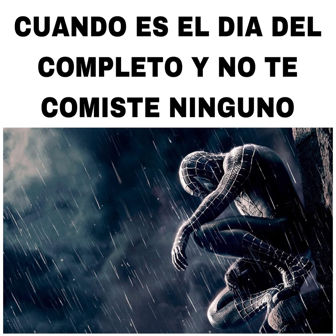

In [16]:
img = PILImage.open('spider.png')
img = img.convert('RGB')
img = img.resize((336, 336))

img

In [70]:
#img.save('tea.png')

In [17]:
conversation = [
            {
                "role": "user",
                "content": [
                    {"type": "image"},
                    {"type": "text", "text": "Eres experto en memes chilenos. Observa la imagen y, si hay texto, interprétalo sin repetirlo. Analiza su sentido usando contexto cultural chileno. Responde según la instrucción."},
                    {"type": "text", "text": "Explica qué significa este meme en Chile, usando lenguaje coloquial chileno."},
                ],
            }
]

text_prompt = processor.apply_chat_template(conversation, add_generation_prompt=True)
batch = processor(text=text_prompt, images=[img], return_tensors="pt").to("cuda")

input_ids = batch["input_ids"]
attention_mask = batch["attention_mask"]
pixel_values = batch["pixel_values"]
image_sizes = batch["image_sizes"]

In [18]:
generated_ids_original = model_original.generate(input_ids=input_ids, attention_mask=attention_mask,
                                    pixel_values=pixel_values, image_sizes=image_sizes, max_new_tokens=MAX_LENGTH)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


In [19]:
generated_ids_nuevo = model_nuevo.generate(
    input_ids=input_ids,
    attention_mask=attention_mask,
    pixel_values=pixel_values,
    image_sizes=image_sizes,
    max_new_tokens=MAX_LENGTH
)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


In [20]:
predictions_original = processor.batch_decode(generated_ids_original[:, input_ids.size(1):], skip_special_tokens=True)

In [21]:
predictions_nuevo = processor.batch_decode(generated_ids_nuevo[:, input_ids.size(1):], skip_special_tokens=True)

In [22]:
predictions_original[0]

'La imagen muestra a un clown con una expresión de desesperanza o frustración, y hay texto que dice "Traete al Papayón ya va a comenizar el conclave".\n\nEn Chile, "Papayón" es un término coloquial que se utiliza para referirse a una persona que es muy buena en algo, pero que no es capaz de hacerlo de manera efectiva o que se equivoca en el proceso. En este contexto, "Papayón" se utiliza para referirse a alguien que es muy bueno en la comedia, pero que no puede hacerlo de manera efectiva o que se equivoca en el proceso.\n\nEl texto "Traete al Papayón ya va a comenizar el conclave" es una expresión coloquial que se utiliza para indicar que alguien está en una situación difícil o complicada, y que necesita ayuda o intervención para resolverlo. En este contexto, se utiliza para indicar que alguien está en una situación difícil'

In [23]:
predictions_nuevo[0]

'Este meme muestra al clásico payaso de los comederos, que siempre está listo para darle la mano a cualquier desgracia. La frase "Treate al Papayón ya va a comenzar el conclave" es una talla que se refiere a la expectativa de que el Papa, que es el líder de la Iglesia Católica, se tome alguna decisión importante o incluso un escándalo, y el payaso está como si estuviera en la misma, listo para reírse o acompañar en el caos.'